In [1]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
import h5py

import spherex_emu.filepaths as filepaths 
from spherex_emu.emulator import pk_emulator
from spherex_emu.dataset import pk_galaxy_dataset
from spherex_emu.utils import load_config_file, calc_avg_loss, normalize, delta_chi_squared

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 11})
plt.rcParams["legend.frameon"] = False

In [3]:
def make_heatmap(x, y, z, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            if median == True: z_new[j,i] = np.median(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
            else: z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        if median == True: y_new[i] = np.median(y[(x >= x_new[i]) & (x <= x_new[i+1])])
        else: y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_heatmap(params, data, label, extents, cmap, log_scale, median=False):
    names = ["As", "fnl", 'h', 'omega_c', "b1", "bphi"]
    labels= [r"$A_s$", r"$f_{nl}$", r"$h$", r'$\omega_{cdm}$', "$b_1$", "$b_{\phi}$", label]
        
    params = params.copy()
    fig, axs = plt.subplots(len(names),len(names), figsize=(12,12), sharex="col")
    for i in range(len(names)):
        for j in range(len(names)):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], data, 25, median)
                axs[i][j].plot(x, y)
            else:
                X, Y, Z = make_heatmap(params[:,j], params[:,i], data, 25, median)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                
                axs[i,j].xaxis.set_ticks_position('both')
                axs[i,j].yaxis.set_ticks_position('both')
            
            axs[i,j].tick_params(direction="in")
            for item in ([axs[i,j].xaxis.label, axs[i,j].yaxis.label]):
                item.set_fontsize(15)
                    
            #if i != j: axs[i][j].axhline(params_best[i], linestyle="--", c="black")
            #axs[i][j].axvline(params_best[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            #if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                #axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    #axs[5][3].set_xticks([1,2,3,4])
    cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1], size=22)
    cbar.ax.tick_params(labelsize=18) 
    plt.subplots_adjust(wspace=0, hspace=0, right=0.95)
    
    #plt.savefig("../CovNet/Plots/chi2-error.pdf", dpi=300, bbox_inches='tight')

In [4]:
# invcov_raw = np.load(cov_dir+"invcov.npy")

# model_vector = np.random.uniform(size=(1,1,2,25))
# nz, nps, nk, nl = 1, 1, 25, 2
# invcov = invcov_raw.reshape(nz, nk*nps*nl, nk*nps*nl)

# delta = data_vector - model_vector
# delta = np.transpose(delta, (0,1,3,2))
# delta = np.transpose(delta, (1,0,2,3)) # (nps, nz, nk, nl) -> (nz, nps, nk, nl)
# delta = delta.reshape((nz, nps*nk*nl)) # (nz, nps, nk, nl) --> (nz, nps*nk*nl) 

# delta_row = delta[:, np.newaxis, :,] # (nz, 1, nps*nk*nl) 
# delta_col = delta[:, :, np.newaxis,] # (nz, nps*nk*nl, 1) 

# chi2_component = np.matmul(delta_row, np.matmul(invcov_raw, delta_col))[..., 0, 0] # invcov is (nz, nps*nk*nl, nps*nk*nl)
# chi2 = np.sum(chi2_component)

In [5]:
# load the network
emulator_dir = filepaths.base_dir+"/emulators/mlp_2_sample_2_redshift/"
#config_file = "/home/joeadamo/Research/SPHEREx/spherex_emu/configs/network_pars_single_tracer_single_redshift.yaml"
config_dict = load_config_file(emulator_dir+"config.yaml")
k = np.linspace(0.01, 0.25, 25)

emulator = pk_emulator(emulator_dir+"config.yaml")
emulator.load_trained_model()

In [6]:
# load the test dataset
#print(emulator.output_normalizations)
test_data = emulator._load_data("testing", 1., False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config_dict["batch_size"], shuffle=True)

### code for calculating chi squared  

NOTE: Eventually this will need to be upgraded to handle multi-tracer, possibly by implimenting what is done in Cosmo_Inferene

Best training loss   = 21212877029376.0000
Best validation loss = 20700098199552.0000
Average test loss    = 20973163275878.3984


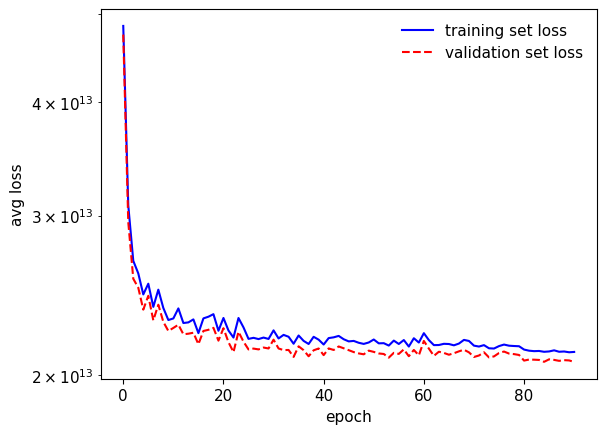

In [6]:
training_data = torch.load(emulator_dir+"train_data.dat")

epochs = range(training_data.shape[1])
train_loss = training_data[0,:]
valid_loss = training_data[1,:]
test_loss = calc_avg_loss(emulator.model, test_loader, emulator.invcov, emulator.loss_function)

print("Best training loss   = {:0.4f}".format(torch.amin(train_loss)))
print("Best validation loss = {:0.4f}".format(torch.amin(valid_loss)))
print("Average test loss    = {:0.4f}".format(test_loss))

plt.plot(epochs, train_loss, c="blue", label="training set loss")
plt.plot(epochs, valid_loss, c="red", ls="--", label="validation set loss")
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.yscale("log")
plt.legend()

In [8]:
# pk_true = np.zeros((len(test_data), 1, 1, 2, 25))
# pk_emu = np.zeros((len(test_data), 1, 1, 2, 25))
# params_neg = []
# idx_neg = []
# for i in tqdm(range(len(test_data))):
#     params = test_data[i][0].detach().numpy()
#     pk_true[i] = test_data.get_power_spectra(i)
#     pk_emu[i] = emulator.get_power_spectra(params)
#     if np.any(pk_true[i,0,0,0,:] < 0):
#         params_neg.append(test_data[i][0].detach().numpy())
#         idx_neg.append(i)
# params_neg = np.array(params_neg)

# fig, ax = plt.subplots(1, 2, figsize=(9,5))
# for i in range(len(test_data)):
#     ax[0].plot(k, pk_true[i,0,0,0,:], c="red", lw=0.1, alpha=0.2)
#     ax[1].plot(k, pk_true[i,0,0,1,:], c="red", lw=0.1, alpha=0.2)

# print(np.amax(pk_true), np.amin(pk_true))

# ax[0].axhline(0, c="black", ls="--")
# ax[1].axhline(0, c="black", ls="--")

# ax[0].set_xlabel("k")
# ax[1].set_xlabel("k")
# #plt.ylim(-10000, 0)

In [12]:
pk_error = []
error_per_bin = np.zeros((2, 25))
delta_chi2 = np.zeros(len(test_data))

for i in tqdm(range(len(test_data))):

    params = test_data[i][0].detach().numpy()
    #params = test_data.get_repeat_params(i, emulator.num_zbins, emulator.num_samples)
    pk_true = test_data.get_power_spectra(i)
    pk_pred = emulator.get_power_spectra(params)
    #chi2 = emulator.loss_function(torch.from_numpy(pk_pred), pk_true, emulator.invcov)
    chi2 = delta_chi_squared(torch.from_numpy(pk_pred).unsqueeze(0), pk_true, emulator.invcov)
    delta_chi2[i] = chi2
    
    #pk_true = normalize(pk_true, config_dict["min_norm_v"], config_dict["max_norm_v"])
    #pk_pred = normalize(pk_pred, config_dict["min_norm_v"], config_dict["max_norm_v"])
    #if np.any(pk_true < 0) == False:
    pk_error.append((pk_pred - pk_true.numpy()) / pk_true)

pk_error = np.array(pk_error)
print(pk_error.shape)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1104.83it/s]

(10000, 2, 3, 2, 25)


mean chi2 error = 12603252933.19
18332.0 2690691891200.0


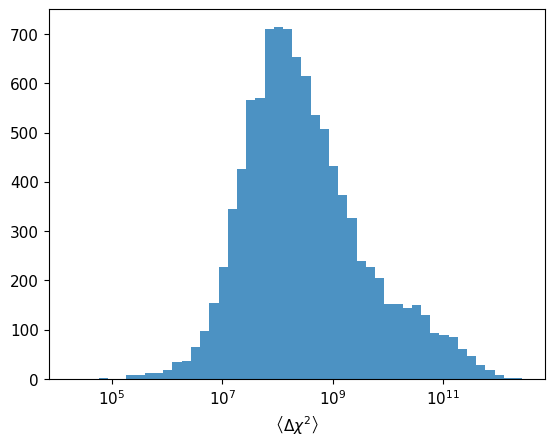

In [13]:
print("mean chi2 error = {:0.2f}".format(np.mean((delta_chi2))))

print(np.amin(delta_chi2), np.amax(delta_chi2))

plt.hist(delta_chi2, bins=np.geomspace(np.amin(delta_chi2), np.amax(delta_chi2), 50), alpha=0.8)
plt.xscale("log")
plt.xlabel(r"$\left< \Delta \chi^2\right>$")
cmap="RdBu"
#extents = [2e6, 1e10]
extents = [-0.15, 0.15]
#plt.hist(chi2_error, bins=40)
#plot_heatmap(test_data.params.detach().numpy(), delta_chi2, r"$|\chi^2_{emulator} - \chi^2_{true}|}$", extents, cmap, False, median=False)

6.829608231782913
Average errror per bin = 43.64% +- 1903.25%
Median errror per bin = 14.04%


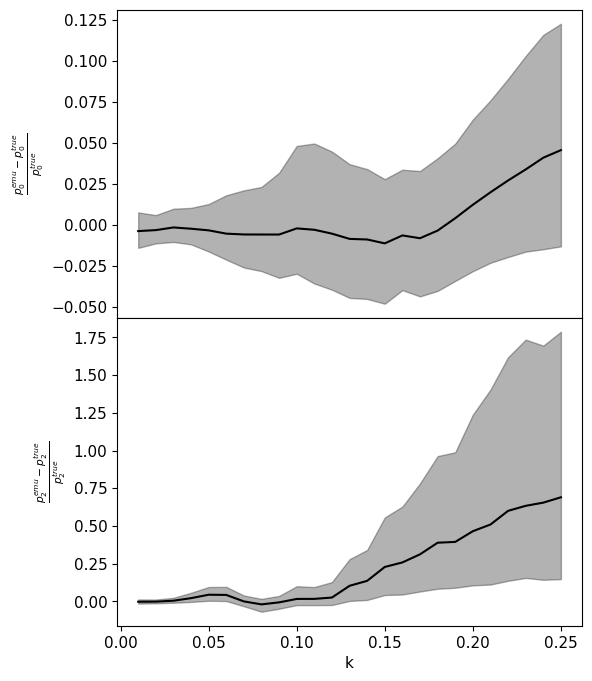

In [14]:
error_mean = np.mean(pk_error, axis=0)[0,0,:,:]
error_std = np.std(pk_error, axis=0)[0,0,:,:]
error_median = np.median(pk_error, axis=0)[0,0,:,:]
error_perc = np.percentile(pk_error, (25, 75), axis=0)[:,0,0,:,:]

print(100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,0])

print("Average errror per bin = {:0.2f}% +- {:0.2f}%".format(100*np.mean(abs(pk_error)), 100*np.std(abs(pk_error))))
#print("Average error per bin per multipole = [{:0.2f}%, {:0.2f}%]".format(100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,0],
#                                                                           100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,1]))
print("Median errror per bin = {:0.2f}%".format(100*np.median(abs(pk_error))))
#print("Median error per bin per multipole = [{:0.2f}%, {:0.2f}%]".format(100*np.median(abs(pk_error), axis=[0, 4])[0,0,0],
#                                                                          100*np.median(abs(pk_error), axis=[0, 4])[0,0,1]))
fig, ax = plt.subplots(2, 1, figsize=(6,8), sharex=True)
# for i in range(0, len(pk_error), 2):
#    ax[0].plot(k, pk_error[i,0,0,0,:], c="red", lw=0.1, alpha=0.1)
#    ax[1].plot(k, pk_error[i,0,0,1,:], c="red", lw=0.1, alpha=0.1)
# ax[0].plot(k, error_mean[0,:], c="black")
# ax[1].plot(k, error_mean[1,:], c="black")
# ax[0].fill_between(k, error_mean[0,:] - error_std[0,:], error_mean[0,:] + error_std[0,:],
#                    color="black", alpha=0.3)
# ax[1].fill_between(k, error_mean[1,:] - error_std[1,:], error_mean[1,:] + error_std[1,:],
#                    color="black", alpha=0.3)
ax[0].plot(k, error_median[0,:], c="black")
ax[1].plot(k, error_median[1,:], c="black")
ax[0].fill_between(k, error_perc[0,0,:], error_perc[1,0,:], color="black", alpha=0.3)
ax[1].fill_between(k, error_perc[0,1,:], error_perc[1,1,:], color="black", alpha=0.3)

# ax[0].plot(k, error_mean[0,0,0,:], c="black")
# ax[1].plot(k, error_mean[0,0,1,:], c="black")
ax[1].set_xlabel("k")
ax[0].set_ylabel(r"$\frac{p_0^{emu} - p_0^{true}}{p_0^{true}}$")
ax[1].set_ylabel(r"$\frac{p_2^{emu} - p_2^{true}}{p_2^{true}}$")
# ax[0].set_ylim(-.2, .2)
# ax[1].set_ylim(-.2, .2)
fig.subplots_adjust(hspace=0)

In [ ]:
# pk_CLASS_PT = np.array([16820.05513766, 23946.48158473, 25453.02712092, 24037.92768727,
#                         21593.59444023, 19017.53002514, 16536.15764868, 14148.70189409,
#                         11847.34712271,  9675.37480162,  7698.56909414,  5957.1104404,
#                         4450.72807379,  3157.2194757,   2057.24458963,  1129.07015037,
#                         336.55155207,  -354.79329047,  -973.23837262, -1530.23765555,
#                        -2011.6919702,  -2406.67233749, -2721.42923145, -2966.09015841, -3155.87940414])

# pk_yosuke = test_data.get_power_spectra(idx_neg[0])

# plt.plot(k, pk_CLASS_PT)
# plt.plot(k, pk_yosuke[0,0,0,:])

## Test individual power spectra

3252
tensor([ 9.5137e-01,  1.4925e-01,  1.5598e-09, -8.5841e+00,  2.6779e+00,
         1.5454e+00,  3.7907e+00,  1.4655e+00])
Average error per bin = 68.35%
Delta chi2 = 22968120.00


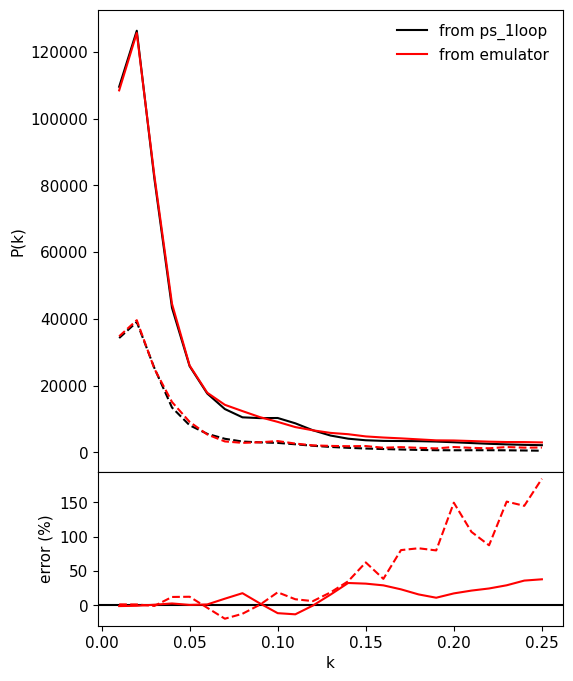

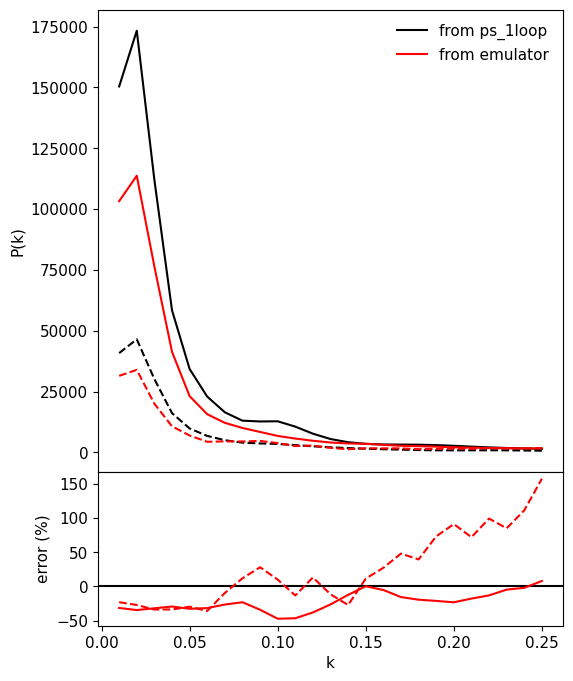

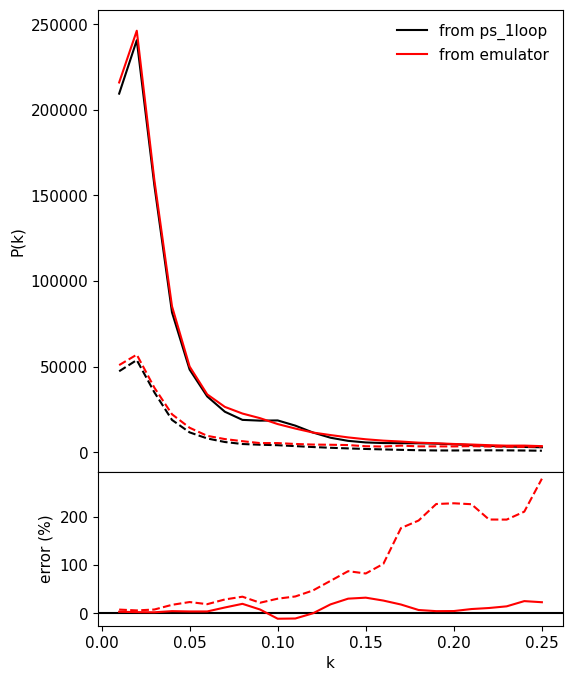

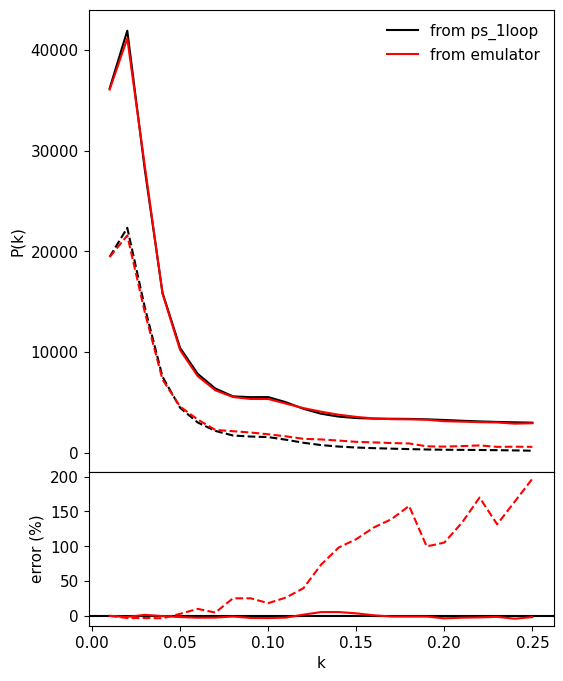

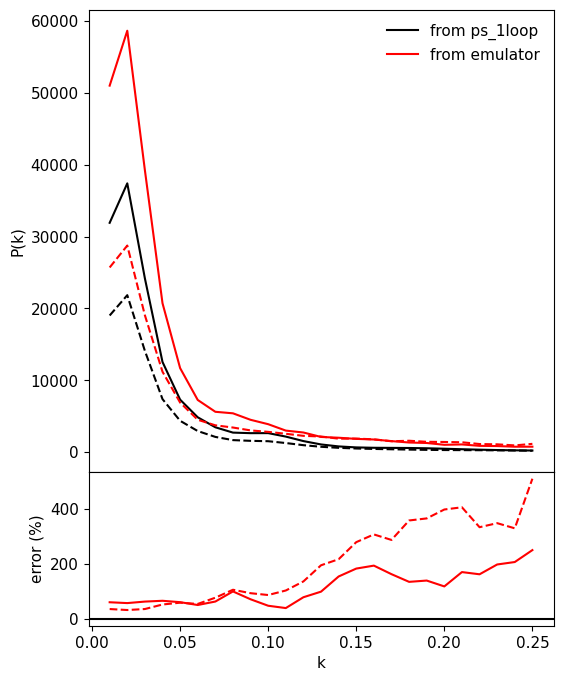

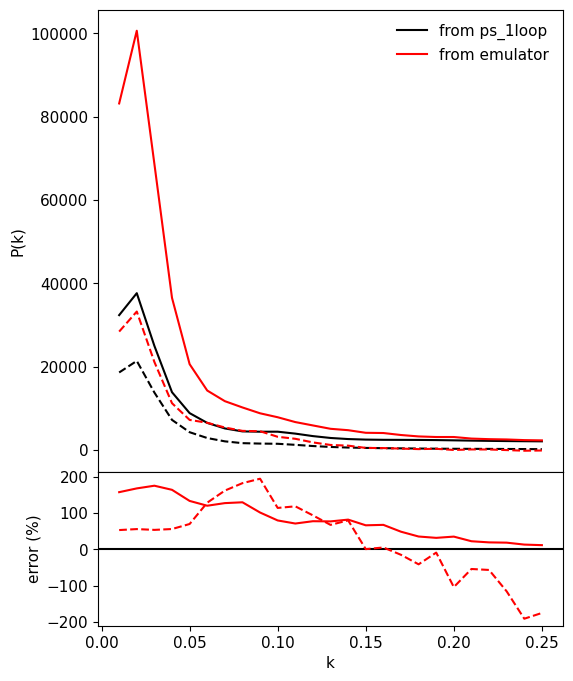

In [7]:
idx = np.random.randint(len(test_data))
#idx = 997
print(idx)

pk_true = test_data.get_power_spectra(idx).numpy()
params = test_data[idx][0]
#params = test_data.get_repeat_params(i, emulator.num_zbins, emulator.num_samples)
print(params)

pk_emu = emulator.get_power_spectra(params.detach().numpy())
#pk_emu = emulator.model.forward(params.unsqueeze(0)).detach().numpy()[0]
error = 100 * (pk_emu - pk_true) / pk_true
d_chi2 = delta_chi_squared(torch.from_numpy(pk_emu).unsqueeze(0), 
                           torch.from_numpy(pk_true), emulator.invcov)

print("Average error per bin = {:0.2f}%".format(np.mean(abs(error))))
print("Delta chi2 = {:0.2f}".format(d_chi2))

for z in range(emulator.num_zbins):
    for s in range(emulator.num_spectra):
        fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        axs[0].plot(k, pk_true[z,s,0,:], c="black", label="from ps_1loop")
        axs[0].plot(k, pk_emu[z,s,0,:], c="red", label="from emulator")
        #axs[0].plot(k, data_vector[:25], c="blue", label="data vector")
        axs[0].plot(k, pk_true[z,s,1,:], c="black", ls="--")
        axs[0].plot(k, pk_emu[z,s,1,:], c="red", ls="--")
        #axs[0].plot(k, data_vector[25:], c="blue", ls="--")
        axs[1].axhline(0, c="black")
        axs[1].plot(k, error[z,s,0,:], c="red")
        axs[1].plot(k, error[z,s,1,:], c="red", ls="--")
        
        axs[1].set_xlabel("k")
        axs[0].set_ylabel("P(k)")
        axs[1].set_ylabel("error (%)")
        axs[0].legend()
        fig.subplots_adjust(hspace=0)

# plt.figure()
# plt.plot(k, pk_raw[0,0,0,:], c="black", label="from ps_1loop")
# #plt.plot(k, pk_raw[1,0,0,:], c="black", label="from ps_1loop")
# plt.plot(k, pk_emu_raw[0,0,0,:], c="red", label="from emulator")
# plt.plot(k, pk_raw[0,0,1,:], c="black", ls="--")
# #plt.plot(k, pk_raw[1,0,1,:], c="black", ls="--")
# plt.plot(k, pk_emu_raw[0,0,1,:], c="red", ls="--")

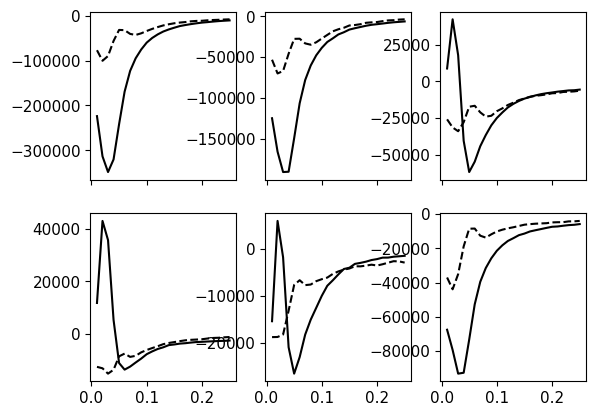

In [12]:
# check that two sets of parameters give different results

idx1 = np.random.randint(len(test_data))
idx2 = np.random.randint(len(test_data))

pk_1 = emulator.get_power_spectra(test_data[idx1][0])
pk_2 = emulator.get_power_spectra(test_data[idx2][0])
diff = pk_1 - pk_2

fig, axs = plt.subplots(emulator.num_zbins, emulator.num_spectra, sharex=True)
for z in range(emulator.num_zbins):
    for s in range(emulator.num_spectra):
        axs[z,s].plot(k, diff[z,s,0,:], c="black")
        axs[z,s].plot(k, diff[z,s,1,:], c="black", ls="--")

## Display results form running optimize_parameters.py

In [ ]:
from matplotlib.ticker import StrMethodFormatter

loss_data = torch.load(emulator_dir+"optimization-data.dat")
loss_data = torch.amin(loss_data, axis=2).detach().numpy()
print(loss_data.shape)
batch_sizes = np.array([100,200,300,400,500])
learning_rates = np.logspace(-4,-2,10)

idx_best = np.where(loss_data[:,:,1] == np.min(loss_data[:,:,1][(loss_data[:,:,1] != 0)]))
print(idx_best)
print("Best loss          = {:0.3e}".format(np.min(loss_data[:,:,1][(loss_data[:,:,1] != 0)])))
print("Best batch size    = {:0.0f}".format(batch_sizes[idx_best[0][0]]))
print("Best learning rate = {:0.3e}".format(learning_rates[idx_best[1][0]]))

img = plt.imshow(loss_data[:,:,0].T, origin="upper")
cbar = plt.colorbar(img)
cbar.set_label("minimum training loss")
plt.xlabel("batch size")
plt.ylabel("initial learning rate")
plt.xticks(np.linspace(0,4,5),  labels=batch_sizes)
plt.yticks(np.linspace(0,9,10), labels=learning_rates)
#plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))

plt.figure()
img = plt.imshow(loss_data[:,:,1].T)
cbar = plt.colorbar(img)
cbar.set_label("minimum validation loss")
plt.xlabel("batch size")
plt.ylabel("initial learning rate")
plt.xticks(np.linspace(0,4,5),  labels=batch_sizes)
plt.yticks(np.linspace(0,9,10), labels=learning_rates)

## Temporary test code

The cells here should not have a long life-span!

In [8]:
cov_dir = filepaths.data_dir+"cov_2_sample_2_redshift/"
cov_raw = np.load(cov_dir+"cov.npy")
invcov = np.load(cov_dir+"invcov_reshape.npy")
print(invcov.shape)
data_vector = np.load(filepaths.data_dir+"ps_fid.npy")
noisy_vector = data_vector + (np.random.uniform(size=data_vector.shape) * 10) - 3
#data_vector = data_vector.flatten()
print(data_vector.shape)

def chi_squared(model_vector):
    delta = data_vector - model_vector
    delta = np.transpose(delta, (0,1,3,2)) # (nz,nps,nl,nk) -> (nz, nps, nk, nl)
    (nz, nps, nk, nl) = delta.shape
    #delta = np.transpose(delta, (1,0,2,3)) # (nps, nz, nk, nl) -> (nz, nps, nk, nl)
    delta = delta.reshape((nz, nps*nk*nl)) # (nz, nps, nk, nl) --> (nz, nps*nk*nl) 
    
    delta_row = delta[:, np.newaxis, :,] # (nz, 1, nps*nk*nl) 
    delta_col = delta[:, :, np.newaxis,] # (nz, nps*nk*nl, 1) 

    # NOTE Matrix multiplication is for the last two indices; element wise for all other indices.
    chi2_component = np.matmul(delta_row, np.matmul(invcov, delta_col))[..., 0, 0] # invcov is (nz, nps*nk*nl, nps*nk*nl)
    chi2 = np.sum(chi2_component)
    return chi2

print(chi_squared(noisy_vector))

(2, 150, 150)
(2, 3, 2, 25)
325.12148095561844


In [9]:
cov_dir = filepaths.data_dir+"cov_2_sample_2_redshift/"
invcov = np.load(cov_dir+"invcov_reshape.npy")
print(invcov.shape)
data_vector = np.load(filepaths.data_dir+"ps_fid.npy")
#noisy_vector = data_vector + (np.random.uniform(size=data_vector.shape) * 10) + 3
#data_vector = data_vector.flatten()
print(data_vector.shape)
data_vector = torch.from_numpy(data_vector)
# noisy_vector = torch.from_numpy(noisy_vector)
invcov = torch.from_numpy(invcov)

def chi_squared(model_vector):
    delta = data_vector - model_vector
    delta = delta.unsqueeze(0)
    delta = torch.vstack((delta, delta, delta))
    print(delta.shape, invcov.shape)
    delta = torch.transpose(delta, 3, 4) # (nz,nps,nl,nk) -> (nz, nps, nk, nl)
    (__, nz, nps, nk, nl) = delta.shape
    #delta = np.transpose(delta, (1,0,2,3)) # (nps, nz, nk, nl) -> (nz, nps, nk, nl)
    delta = delta.reshape((-1, nz, nps*nk*nl)) # (nz, nps, nk, nl) --> (nz, nps*nk*nl) 
    
    delta_row = delta[:, :, None, :,] # (nz, 1, nps*nk*nl) 
    delta_col = delta[:, :, :, None,] # (nz, nps*nk*nl, 1) 

    # NOTE Matrix multiplication is for the last two indices; element wise for all other indices.
    chi2_component = torch.matmul(delta_row, torch.matmul(invcov, delta_col))[..., 0, 0] # invcov is (nz, nps*nk*nl, nps*nk*nl)
    chi2 = torch.sum(chi2_component)
    return chi2

print(chi_squared(noisy_vector))

(2, 150, 150)
(2, 3, 2, 25)
torch.Size([3, 2, 3, 2, 25]) torch.Size([2, 150, 150])
tensor(975.3644, dtype=torch.float64)


In [ ]:
import math, itertools

def organize_params(params, num_cosmo_params, num_bias_params, num_samples=1, num_zbins=1):
    """returns an expanded list of parameters with each bias parameter repeated
       num_samples times (shuffled)"""

    if num_samples*num_zbins == 1: return params
    num_spectra = num_samples + math.comb(num_samples, 2)
    new_params = torch.zeros((params.shape[0], num_spectra*num_zbins, num_cosmo_params+(num_bias_params*2)))

    for i in range(num_zbins):
        idx = 0
        for isample1, isample2 in itertools.product(range(num_spectra), repeat=2):
            if isample1 > isample2: continue
            new_params[:, idx, :num_cosmo_params] = params[:,:num_cosmo_params]
            idx1 = num_cosmo_params + (isample1*num_bias_params)
            idx2 = num_cosmo_params + (isample2*num_bias_params)
            new_params[:, idx, num_cosmo_params::2] = params[:,idx1:idx1+num_bias_params]
            new_params[:, idx, num_cosmo_params+1::2] = params[:,idx2:idx2+num_bias_params]
            idx+=1
    return new_params

# for isample1, isample2 in itertools.product(range(4), repeat=2):
#     if isample1 > isample2: continue
#     print(isample1, isample2)
#     print(isample1*isample2 + isample2)

In [ ]:
def rearange_diagonal(mat, num_kbins):
    """rearange the diagonal so it's in order of ells"""
    new_diag = mat.copy()
    for i in range(mat.shape[0]):
        

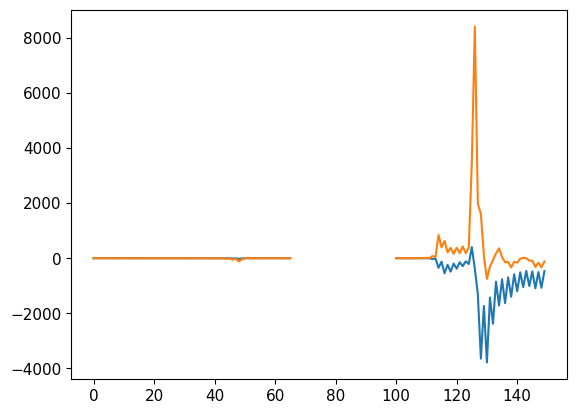

In [14]:
# cov_dir = filepaths.data_dir+"cov_2_sample_2_redshift/"
cov = torch.from_numpy(np.load(cov_dir+"cov_reshape.npy"))
# invcov = torch.from_numpy(np.load(cov_dir+"invcov_reshape.npy"))
#cov = torch.load(filepaths.base_dir+emulator.config_dict["training_dir"]+"data_cov.dat")
idx = np.random.randint(len(test_data))

#pk_fid = torch.transpose(data_vector, 2, 3).to(torch.float32)
pk_fid = data_vector.to(torch.float32)
pk_test = test_data[idx][1]

pk_norm = torch.zeros((2, 150))
# for now since we're dealing with diagonal covariance, don't worry about the U matrix
for z in range(cov.shape[0]):
    #invcov_diag = torch.diag(invcov[z])
    #test = torch.linalg.cholesky(cov[z])
    #L, V = torch.linalg.eig(cov[z])
    #V = V.to(torch.float32)
    #pk_test_flat = torch.transpose(pk_test[z], 1, 2).flatten()
    pk_test_flat = pk_test[z].flatten()
    #plt.plot(invcov_diag)
    #plt.plot(pk_test_flat, c="black")
    #plt.plot(pk_fid[z].flatten())
    #plt.plot(abs(L))
    #print(pk_test_flat, pk_fid[z].flatten().shape, invcov_diag.shape)
    pk_norm[z] = ((pk_test_flat) - (pk_fid[z].flatten())) / torch.sqrt(torch.diag(cov[z]))
    plt.plot(pk_norm[z])
#plt.yscale("log")